In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
sys.path.append("..")
from src import *
from matplotlib.patches import Patch

2024-08-05 13:49:43.886950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 13:49:43.900118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:49:43.916597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:49:43.921434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 13:49:43.933535: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"
config_path = "/data/bionets/je30bery/melanoma_data/config.json" if "ramses" in os.uname()[1] else "/data_nfs/je30bery/melanoma_data/config.json"

In [4]:
data = get_data_csv(high_quality_only=False, pfs=True, config_path=config_path)
data = data.reset_index().drop("index", axis=1)

data["Sex"].replace({"m": 1., "f": 0.}, inplace=True)
data["Ulcerated"].replace({True: 1., False: 0.}, inplace=True)
#data["Coarse loc"] = data["Localization"].apply(lambda x: coarse_loc(x)).astype(float)
#data["Side"] = data["Localization"].apply(lambda x: left_right(x)).astype(float)

In [5]:
def get_features(model, x):
    x = model.res.conv1(x)
    x = model.res.bn1(x)
    x = model.res.relu(x)
    x = model.res.maxpool(x)
    x = model.res.layer1(x)
    x = model.res.layer2(x)
    x = model.res.layer3(x)
    x = model.res.layer4(x)
    x = model.res.avgpool(x)
    return x.detach().cpu().numpy().flatten()

In [6]:
with open(config_path, "r") as f:
    configs = json.load(f)
    dataset_statistics = configs["dataset_statistics"]
    checkpoint_path = configs["downloaded_model_weights"]
    pretrained_model = configs["pretrained_model_path"]

with open(os.path.join(dataset_statistics, f'melanoma_means.json'), 'r') as fp:
    means = json.load(fp)
    markers = list(means.keys())

In [8]:
model = ResNet18_pretrained(indim=len(markers), checkpoint_path=checkpoint_path)
model.load_state_dict(t.load(pretrained_model, map_location="cpu"))

# model = model.cuda()
model = model.eval()

dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=True, data=data, mode="val", config_path=config_path), batch_size=1, shuffle=False)
it = iter(dl)
features = list()
labels = list()
while True:
    try:
        x, y, _ = next(it)
        labels.append(y.detach().cpu().numpy()[0])
        features.append(get_features(model, x))
    except StopIteration:
        break
conc = np.array(features)

In [9]:
data[list(range(512))] = conc

In [10]:
from sklearn.decomposition import PCA

In [11]:
clf = PCA(2)
transformed = clf.fit_transform(data[list(range(512))])
data["PC1"] = transformed[:, 0]
data["PC2"] = transformed[:, 1]

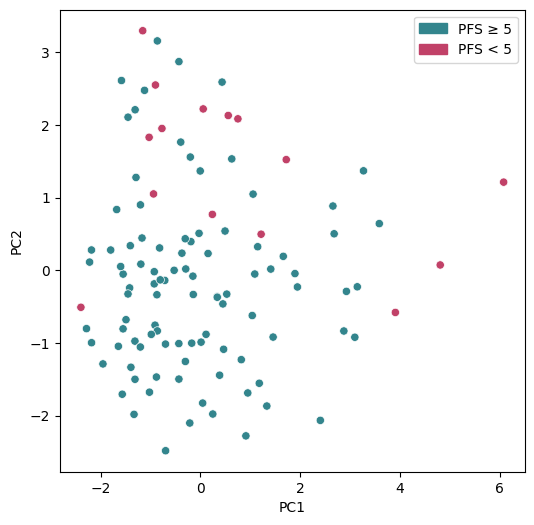

In [13]:
f = plt.figure(figsize=(6, 6))
palette = {0: sns.color_palette("crest", 1)[0], 1: sns.color_palette("flare", 1)[0]}
sns.scatterplot(data, x="PC1", y="PC2", hue="PFS < 5", palette=palette)
palette = {"PFS ≥ 5": sns.color_palette("crest", 1)[0], "PFS < 5": sns.color_palette("flare", 1)[0]}
legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
plt.legend(handles=legend_handles, frameon=True)
plt.show()
#plt.savefig("PCA.pdf")

In [19]:
predictions, feature_imp = loo_forest(data=data.reset_index(), features=list(range(512)), label="PFS < 5")
data = data.sort_values("Histo ID", axis=0)
predictions = predictions.sort_values("Histo ID", axis=0)
print("------- Histo ID level -------")
y_true, y_pred = get_histo_id_level_predictions(data, predictions)
print_metrics(np.array(y_true), np.array(y_pred))

------- Histo ID level -------
Accuracy 0.7142857142857143
F1 0.0
AUC-ROC 0.5
Recall 0.0
Precision 0.0
Accuracy in negative class 1.0
Accuracy in positive class 0.0
Sensitivity (Recall): 0.0
Specificity: 1.0
